In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
import pandas as pd
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-07-30 14:11:58,914 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-07-30 14:11:58,915 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


# Load Data

In [3]:
# experiment specific
result_base_dir = "frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80"

In [4]:
# edit experiment specific data path and config
import json

result_parent_dir = "/cmnfs/proj /ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/"

result_dir = os.path.join(result_parent_dir, result_base_dir)
with open(os.path.join(result_dir, "param.json"), mode="r", encoding="utf-8") as file:
    config = json.load(file)

maxquant_file_exp = config["MQ_exp_path"]
maxquant_file_ref = os.path.join(result_dir, "maxquant_result_ref.pkl")

In [7]:
maxquant_offline_path = "/cmnfs/proj/ORIGINS/data/brain/txt_3x13Brainregions_MBR_LFQ_iBAQ/evidence_freshfrozen_modseq_charge_1_FilteredByClosestRT_transfer_RT_pred_filtered_withIso.pkl"
maxquant_offline = pd.read_pickle(maxquant_offline_path)

In [11]:
maxquant_offline["observed_retention_time"].describe()
maxquant_offline["Calibrated retention time"].describe()

count    259551.000000
mean         13.029509
std           5.345883
min           0.938190
25%           9.003900
50%          12.868000
75%          16.808000
max          28.239000
Name: observed_retention_time, dtype: float64

count    259551.000000
mean         11.019069
std           5.353228
min          -1.942800
25%           6.955300
50%          10.886000
75%          14.840000
max          28.237000
Name: Calibrated retention time, dtype: float64

In [5]:
maxquant_result_dict = pd.read_pickle(filepath_or_buffer=maxquant_file_ref)
maxquant_result_exp = pd.read_csv(maxquant_file_exp, sep="\t", low_memory=False)
ms1scans = pd.read_csv(os.path.join(result_dir, "ms1scans.csv"), index_col=0)
mobility_values_df = pd.read_csv(
    os.path.join(result_dir, "mobility_values.csv"), index_col=0
)

# Compare with maxquant_result_exp

In [3]:
maxquant_result_ref = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/tims_ramp_time/HeLa_library/txt_Hela_DDA_120min/evidence.txt",
    sep="\t",
    low_memory=False,
)
maxquant_result_exp = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/tims_ramp_time/combined/txt/evidence_80ms.txt",
    sep="\t",
    low_memory=False,
)

In [9]:
%autoreload 2
from prepare_dict.prepare_dict import merge_ref_and_exp
maxquant_result_merged = merge_ref_and_exp(maxquant_ref_df=maxquant_result_ref, maxquant_exp_df=maxquant_result_exp, save_dir = '/cmnfs/proj/ORIGINS/data/tims_ramp_time/combined/txt/')

2024-07-30 14:32:18,976 - utils.tools - INFO - Removing 189 decoys from file, 228532 entries left.
2024-07-30 14:32:19,050 - utils.tools - INFO - Removing 27 decoys from file, 35008 entries left.
2024-07-30 14:32:19,118 - utils.tools - INFO - Removing 431 duplicate entries from experiment file, 34577 entries left.


In [22]:
%autoreload 2
from prepare_dict.prepare_dict import concat_decoy_and_target

maxquant_full_dict = concat_decoy_and_target(maxquant_result_merged)

2024-07-30 14:40:04,990 - prepare_dict.prepare_dict - INFO - Number of decoys generated: 89730
2024-07-30 14:40:05,071 - prepare_dict.prepare_dict - INFO - Number of decoys after removing decoys identical to any targets: 89730, 0 are removed


In [30]:
maxquant_full_dict.loc[5995, ["Sequence", "Modified sequence"]]

,Sequence,Modified sequence
5995,ASSQVLSESPSQDSLDAFMSEMK,_ASSQVLSESPSQDSLDAFMSEM(Oxidation (M))K_
5995,ATSQVLSESPSQDSLDAFMSELK,_ATSQVLSESPSQDSLDAFMSEL(Oxidation (M))K_


In [63]:
from result_analysis.compare_maxquant import (
    merge_with_maxquant_exp,
    evaluate_rt_overlap,
)
from utils.tools import cleanup_maxquant

maxquant_result_exp = cleanup_maxquant(
    maxquant_result_exp, remove_decoys=True, how_duplicates="keep_highest_int"
)

2024-07-31 09:27:18,717 - utils.tools - INFO - Removing 27 decoys from file, 35008 entries left.
2024-07-31 09:27:18,786 - utils.tools - INFO - Removing 431 duplicate entries from experiment file, 34577 entries left.


In [7]:
maxquant_result_dict.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Fraction', 'Experiment',
       'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/

2024-06-05 11:08:02,655 - result_analysis.compare_maxquant - DEBUG - Experiment file has 35127 entries.
2024-06-05 11:08:02,656 - result_analysis.compare_maxquant - DEBUG - Merged file has 35127 entries.
2024-06-05 11:08:03,198 - result_analysis.compare_maxquant - INFO - RT overlap counts: full_overlap       32567
no_overlap          1204
partial_overlap      762
no_entry_in_ref      594
Name: RT_overlap, dtype: int64
2024-06-05 11:08:03,210 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-05 11:08:03,211 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-05 11:08:03,215 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-06-05 11:08:03,216 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-

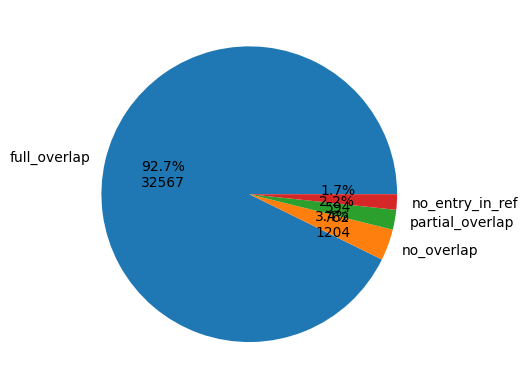

In [8]:
maxquant_result_merged = merge_with_maxquant_exp(
    maxquant_result_exp,
    maxquant_result_dict,
    exp_cols=[
        "Ion mobility index",
        "Ion mobility length",
        "1/K0",
        "1/K0 length",
        "Calibrated 1/K0",
        "CCS",
        "Calibrated CCS",
        "CCS length",
    ],
    ref_cols=["mobility_values", "mobility_values_index"],
)
maxquant_result_merged = evaluate_rt_overlap(maxquant_result_merged)

In [11]:
from result_analysis.compare_maxquant import filter_merged_by_rt_overlap

maxquant_result_merged = filter_merged_by_rt_overlap(
    maxquant_result_merged, ["full_overlap"]
)

2024-06-05 11:08:22,783 - result_analysis.compare_maxquant - INFO - Removing 0 entries with RT_overlap not in ['full_overlap'], 32567 entries left.
2024-06-05 11:08:22,784 - result_analysis.compare_maxquant - DEBUG - columns after filter by RT 32567


2024-06-05 11:25:49,717 - result_analysis.compare_maxquant - INFO - IM overlap counts: full_overlap       31029
partial_overlap     1176
no_overlap           362
Name: IM_overlap, dtype: int64


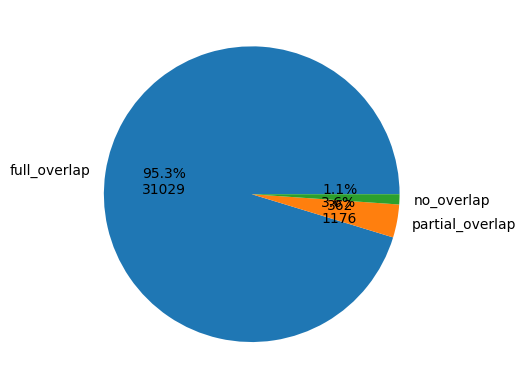

In [18]:
%autoreload 2
from result_analysis.compare_maxquant import evaluate_im_overlap

maxquant_result_merged = evaluate_im_overlap(maxquant_result_merged, delta_im = 0.07)

In [19]:
from result_analysis.compare_maxquant import filter_merged_by_im_overlap

maxquant_result_merged = filter_merged_by_im_overlap(
    maxquant_result_merged, ["full_overlap"]
)

2024-06-05 11:27:20,956 - result_analysis.compare_maxquant - INFO - Removing 1538 entries with IM_overlap not in ['full_overlap'], 31029 entries left.
2024-06-05 11:27:20,957 - result_analysis.compare_maxquant - DEBUG - columns after filter by IM 31029


In [20]:
maxquant_result_merged.to_pickle(
    path=os.path.join(result_dir, "maxquant_result_merged_cleaned.pkl")
)

<Axes: >

Text(0.5, 1.0, 'm/z distribution of cleaned up MaxQuant single shot experiment results')

2024-05-29 15:42:32,503 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-05-29 15:42:32,504 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2024-05-29 15:42:32,504 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-05-29 15:42:32,505 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.

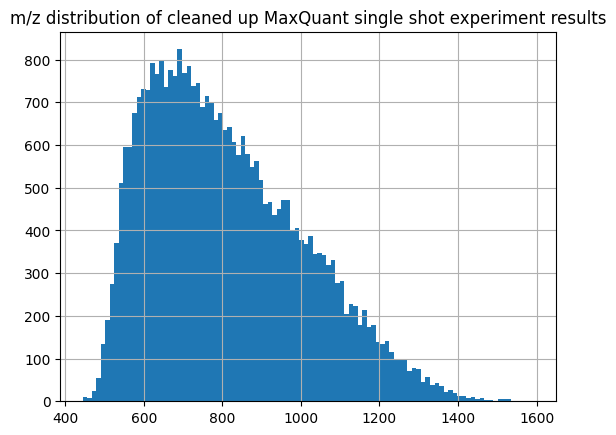

In [13]:
import matplotlib.pyplot as plt

maxquant_result_merged["m/z"].hist(bins=100)
plt.title("m/z distribution of cleaned up MaxQuant single shot experiment results")

<Axes: >

Text(0.5, 1.0, 'm/z distribution of cleaned up MaxQuantn Dictionary results')

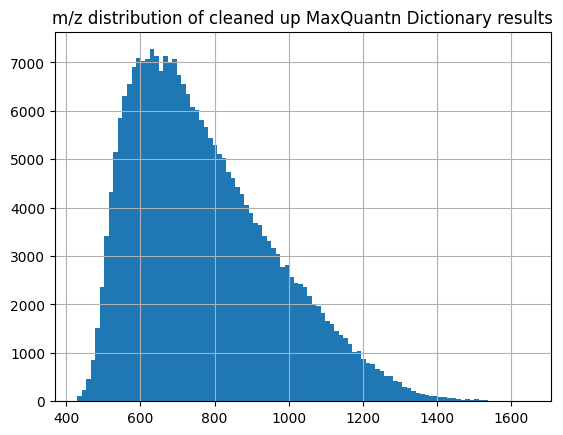

In [14]:
maxquant_result_dict["m/z"].hist(bins=100)
plt.title("m/z distribution of cleaned up MaxQuantn Dictionary results")

# Statistics

## Determine image size
With RT search range 1.8 minutes (0.9 minutes * 2), and IM search range of 0.08 (delta IM = 0.04), calculate the maximum RT range and IM range in terms of index number for padding input data

In [ ]:
pd.cut(mobility_values_df["mobility_values"], bins=5).value_counts()

(1.224, 1.317]    189
(1.037, 1.13]     188
(1.13, 1.224]     188
(0.85, 0.943]     186
(0.943, 1.037]    186
Name: mobility_values, dtype: int64

In [ ]:
pd.cut(ms1scans["Time_minute"], bins=20).value_counts()

(-0.03, 1.499]      374
(28.485, 29.985]     79
(2.998, 4.498]       77
(19.49, 20.989]      77
(26.986, 28.485]     77
(7.496, 8.995]       77
(8.995, 10.495]      77
(25.487, 26.986]     77
(13.493, 14.992]     77
(22.488, 23.988]     77
(4.498, 5.997]       77
(23.988, 25.487]     76
(20.989, 22.488]     76
(16.492, 17.991]     76
(17.991, 19.49]      76
(1.499, 2.998]       76
(11.994, 13.493]     76
(10.495, 11.994]     76
(5.997, 7.496]       76
(14.992, 16.492]     76
Name: Time_minute, dtype: int64

Set image size 180*180

In [ ]:
Maxquant_result_dict.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'Experiment', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Resolution', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Match time difference',
       'Match m/z difference', 'Match q-value', 'Match score',
       'Number of data points', 'Number of scans', 'Number of isotopic peaks',
       'PIF', 'Fraction of total spectrum', 'Base 